In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import tellurium as te
from odbm.odbm import ModelBuilder
import matplotlib.pyplot as plt
from odbm.vis import rxn_plot


C:\Users\dex36\miniconda2\envs\ODBM\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\dex36\miniconda2\envs\ODBM\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\dex36\miniconda2\envs\ODBM\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
model_species = pd.read_excel('Examples/multi_enzyme_model.xlsx', sheet_name = 'Species & Base Mechanisms', engine = 'openpyxl')
model_rxns = pd.read_excel('Examples/multi_enzyme_model.xlsx', sheet_name = 'Reaction', engine = 'openpyxl')

In [3]:
txtl_load = 0.05 
N_enzymes = 3
load_fudge = 1/10
enzymeInit = txtl_load/N_enzymes*load_fudge

solubilities = {    'ATP' : 98.619,
                    'Serine': 2380.952,
                    'HCO3' : 1470.588,
                    'NADH' : 150.739 
                }
sol_fudge = 1/20
solubilities = {k:v*sol_fudge for k,v in solubilities.items()}

for k,v in solubilities.items():
    model_species.loc[model_species['Label'] == k,'StartingConc'] = v

serine_mw = 105.09
malate_mw = 134.0874

In [4]:
modelfile = 'Examples/multi_enzyme_model.txt'
myModel = ModelBuilder(model_species, model_rxns)
myModel.saveModel(modelfile)

model = open(modelfile,'r').read()
r  = te.loada(model)

sdaV = list(map(lambda x:x.upper(),model_species[['Sda' in s for s in model_species['Label']]]['Label']))
pcxV = list(map(lambda x:x.upper(),model_species[['PCX' in s for s in model_species['Label']]]['Label']))
mdhV = list(map(lambda x:x.upper(),model_species[['Mdh' in s for s in model_species['Label']]]['Label']))

In [5]:
results_id = np.empty((len(sdaV), len(pcxV), len(mdhV)), dtype=int)
results = []

count = 0
for i,sda in enumerate(sdaV):
    for j,pcx in enumerate(pcxV):
        for k,mdh in enumerate(mdhV):
            r['['+sda+']'] = enzymeInit
            r['['+pcx+']'] = enzymeInit
            r['['+mdh+']'] = enzymeInit
            results_id[i,j,k] = count
            results.append(r.simulate(0,1200,1000))
            r.reset()
            count += 1

In [6]:

# for sim in results[16:24]:
#     plt.figure()
#     for species in sim[1:]:
#         plt.plot(sim[0],species)
#     # plt.legend(labels = ['Serine','Pyruvate','Oxaloacetate', 'Malate'])



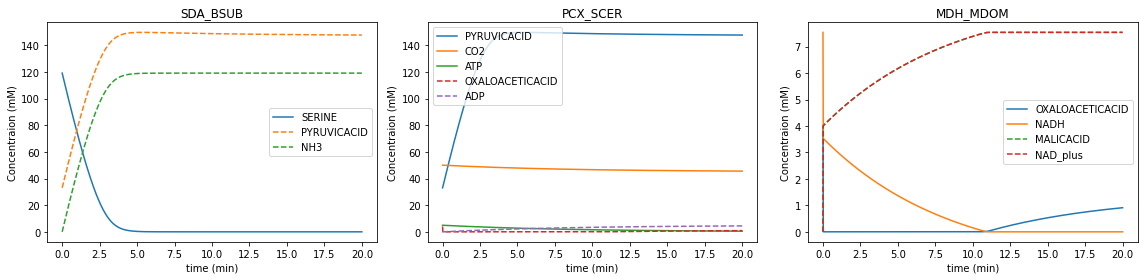

In [7]:
variants = (1,1,1)
v_labels = [v[k] for v,k in zip([sdaV, pcxV, mdhV], variants)]
run = int(results_id[variants])
rxns = [variants[0],variants[1]+4, variants[2]+8]
rxn_plot(myModel, results[run], rxns, figsize=(16,4), titles = v_labels);

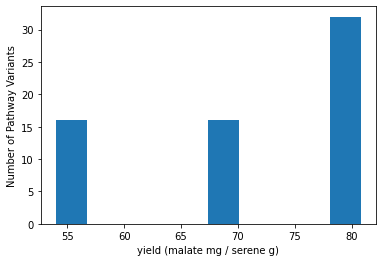

In [8]:
plt.hist([((r['[MALICACID]'][-1]*malate_mw)/(r['[SERINE]'][0]*serine_mw)*1000) for r in results]);
plt.xlabel('yield (malate mg / serene g)');
plt.ylabel('Number of Pathway Variants');